In [1]:
using Plots;
gadfly();

INFO: Recompiling stale cache file /home/kryosugarra/.julia/lib/v0.4/Plots.ji for module Plots.
INFO: Recompiling stale cache file /home/kryosugarra/.julia/lib/v0.4/KernelDensity.ji for module KernelDensity.
INFO: Recompiling stale cache file /home/kryosugarra/.julia/lib/v0.4/Distributions.ji for module Distributions.


### Load FDTD functions

In [20]:
include("../fdtd/update.jl");
include("../fdtd/sources.jl");
include("../fdtd/boundaries.jl");
using update;
using sources;

### Define grid

In [35]:
#Global parameters
size = 200
endTime = 700
num_snaps = 350
snap_step = div(endTime, num_snaps)
#Grid
hy = zeros(size);
ez = zeros(size);
# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

fieldsum = 1;
minsumtime = 1;
minfieldsnap = zeros(size);

### Run simulation

In [36]:
#Time steps

for time in 1:endTime
    #Field update equations
    
    update.update_magnetic_field!(ez, hy)
    boundaries.perfect_conductor!(hy, 200)
    
    update.update_electric_field!(ez, hy)
    boundaries.perfect_conductor!(ez, 1)

    # Source at center
    sources.additive_gaussian_source!(ez, div(length(ez),2), time, 70, 100)

    #Boundaries

    
    #Catch minimum E-Field
    if time > 50
        if fieldsum > sum(ez.^2)
            minsumtime = time
            fieldsum = sum(ez.^2)
            minfieldsnap = copy(ez)
        end
    end
    
    #Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end
print(minsumtime, '\n')
print(fieldsum)

269
6.222615632749751e-29

### E-field animation

In [38]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(150, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "PEC")])
    plot!(ann=[(180, 1.1, "PMC")])    
    plot!(xlims=(1, 200), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task0/PEC-PMC.gif", fps=15)

INFO: Saved animation to /media/storage/Documents/Github/1d-fdtd/tasks/Task0/PEC-PMC.gif


Plots.AnimatedGif("/media/storage/Documents/Github/1d-fdtd/tasks/Task0/PEC-PMC.gif")

### Minimum E-field snapshot

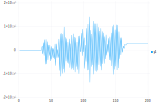

In [37]:
plot(1:size, minfieldsnap)